# Why Differentiable Spectral Modeling?

Last Update: January 19th (2025) Hajime Kawahara

[ExoJAX](https://github.com/HajimeKawahara/exojax) is a differentiable spectral model written in [JAX](https://jax.readthedocs.io/en/latest/). Here, we aim to provide a brief introduction to what can be achieved with differentiable models for users who may not be familiar with [Differential Programming](https://arxiv.org/abs/2403.14606) (DP).

Here, as the simplest example of a spectrum, we use an absorption spectrum consisting of a single hypothetical absorption line of a molecule X.
This absorption line follows a Voigt profile, characterized by a line profile centered at `nu0` , determined by the temperature-dependent core width `beta` and the temperature- and pressure-dependent wing width  `gamma` . The cross-section is given as follows:

Text(0, 0.5, 'cross section (cm$^2$)')

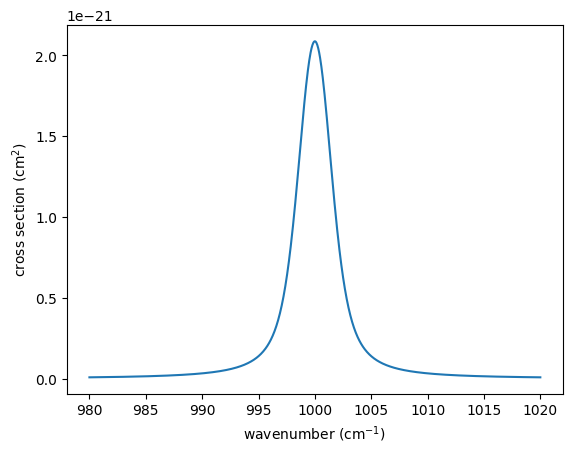

In [10]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from exojax.spec import voigt

beta = 1.0
gamma = 1.0
line_strength = 1.e-20 #cm2
nu0 = 1000.0
nu_grid = jnp.linspace(nu0-20,nu0+20,1000)


sigma = line_strength*voigt(nu_grid - nu0,beta,gamma)

plt.plot(nu_grid, sigma) 
plt.xlabel("wavenumber (cm$^{-1}$)")
plt.ylabel("cross section (cm$^2$)")

When light with a flat spectrum $ f_0 $ passes through a region filled with molecule X at a number density $ n $ over a path length $ L $, the transmitted spectrum is given by $ f_0 \exp(-\tau_\nu) $, where the optical depth $ \tau_\nu = n L \sigma_\nu $. Using the column density $ N = n L $, this can be expressed as 
$f_\nu = f_0 \exp{(-N \sigma_\nu )} $.

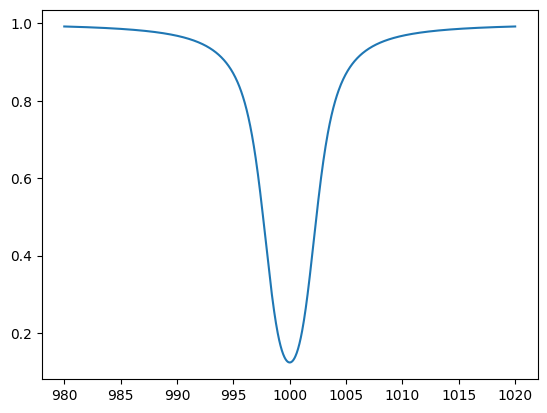

In [16]:
f0 = jnp.ones_like(nu_grid)
n = 1.e17
L = 1.e4
N = n*L
f = f0*jnp.exp(-sigma*N)

plt.plot(nu_grid, f)
plt.show()

Observed spectra always contain statistical errors. Here, we simplify by assuming wavenumber-independent Gaussian noise and add noise accordingly.

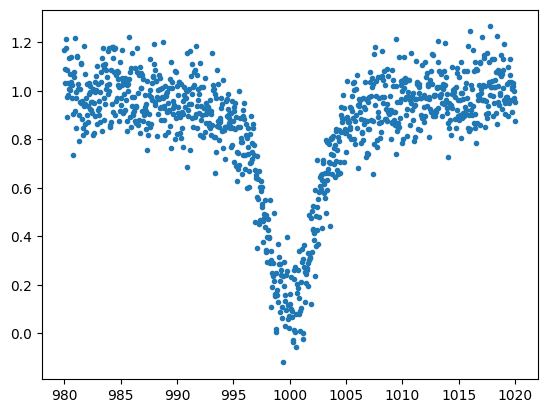

In [78]:
import numpy as np
sigma_noise = 0.1
np.random.seed(0)
fobs = f + np.random.normal(0.0,sigma_noise,len(f))
plt.plot(nu_grid, fobs, ".")
plt.show()

Now, what can a differentiable spectral model do with this observed spectrum? Let’s first assume that `gamma` is known and focus on estimating `N` and `beta`.

In [79]:
def fmodel(N,beta):
    gamma=1.0
    nu0 = 1000.0
    sigma = line_strength*voigt(nu_grid - nu0,beta,gamma)
    f = f0*jnp.exp(-sigma*N)
    return f

## gradient-based optimization

In a differentiable spectral model, gradient-based optimization is possible. Specifically, when $ \chi^2 $ is expressed as a function of `N` (normalized by 1e21) and `beta`, we can compute the gradients of $ \chi^2 $ with respect to `N` and `beta`. This allows us to determine the next step that minimizes $\chi^2 $, following the same principle as descending along the slope of a hill toward the valley bottom. 

In [80]:
def chi2_fmodel(logN,logbeta):
    """differentiable chi2 function
    Args:
        logN (float): log surface density
        logbeta (float): log beta

    Returns:
        float: chi2
    """
    f = fmodel(10**logN,10**logbeta)
    return jnp.sum((f-fobs)**2/sigma_noise**2)

Text(0, 0.5, 'log beta')

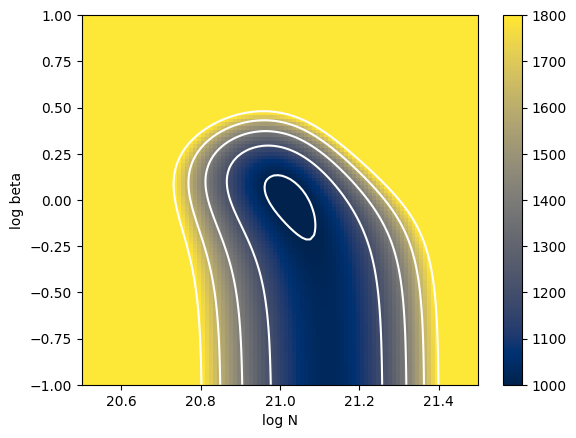

In [83]:
Narray = jnp.linspace(20.5,21.5,100)
betaarray = jnp.linspace(-1,1,100)

from jax import vmap
vmapchi2 = vmap(vmap(chi2_fmodel,(0,None),0),(None,0),0)
chi2arr = vmapchi2(Narray,betaarray)

a = plt.imshow(chi2arr[::-1,:], extent=(Narray[0], Narray[-1], betaarray[0], betaarray[-1]), aspect='auto', cmap='cividis', vmin=1000, vmax=1800)
cb = plt.colorbar(a)
plt.contour( Narray, betaarray, chi2arr, levels=[1000,1200,1400,1600,1800], colors='white')
plt.xlabel("log N")
plt.ylabel("log beta")


The key point here is that the $ \chi^2 $ defined using a differentiable spectral model is itself differentiable with respect to the parameters.

In [84]:
from jax import grad
dchi2 = grad(chi2_fmodel,argnums=(0,1))
logNinit = 20.75
logbetainit = 0.5
dchi2(logNinit,logbetainit)

(Array(-5780.8774, dtype=float32, weak_type=True),
 Array(4569.641, dtype=float32, weak_type=True))